In [2]:
import s3fs
import h5py
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import requests
import boto3
import s3fs
from os.path import dirname, join
from pprint import pprint
from pyresample import kd_tree, geometry, utils
from pyresample.geometry import GridDefinition
from pathlib import Path
import os

### Confirm Existence of .netrc file in your home directory

In [3]:
# make a .netrc file in your home directory with the following
# machine urs.earthdata.nasa.gov login ifenty password XCfK5QhgEGuWVgu4qRuH
# for login and password use your EarthData login

# if this command returns 1, you are good

#to create .netrc file, type in terminal: echo "machine urs.earthdata.nasa.gov login severinf password Calin0852" > ~/.netrc

In [4]:
!cat ~/.netrc | grep 'urs.earthdata.nasa.gov' | wc -l

1


### Get credentials

In [5]:
%%capture
import requests

def store_aws_keys(endpoint: str="https://archive.podaac.earthdata.nasa.gov/s3credentials"):    
    with requests.get(endpoint, "w") as r:
        accessKeyId, secretAccessKey, sessionToken, expiration = list(r.json().values())

    creds ={}
    creds['AccessKeyId'] = accessKeyId
    creds['SecretAccessKey'] = secretAccessKey
    creds['SessionToken'] = sessionToken
    creds['expiration'] = expiration
    
    return creds

creds = store_aws_keys()
print(creds)

In [6]:
print(f"\nThe current session token expires at {creds['expiration']}.\n")


The current session token expires at 2022-03-18 23:02:10+00:00.



# Define important params

In [7]:
# ECCO Starts on Jan 1, 1992
ECCO_start_time= np.datetime64('1992-01-01')
alongtrack_file_dir = Path('/efs/ifenty/')
print(alongtrack_file_dir)

# output directory
output_dir=Path('/efs/ifenty/ECCO_V4r4_alongtrack_output')
output_dir.mkdir(exist_ok=True)
print(output_dir)


~/GMSL
ECCO_V4r4_alongtrack_output


# Make a map of grid cell areas and calculate total ocean area

needed to calculate 'true' global mean sea level from ECCO

## Download the ECCO grid geometry file locally

In [8]:
# subroutine to download a file from S3 to the local machine
def download(source: str):
    target = os.path.basename(source.split("?")[0])
    
    if not os.path.isfile(target):
        !wget --quiet --continue --output-document $target $source
    
    return target

In [9]:
ECCO_grid_url = "https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/ECCO_L4_GEOMETRY_05DEG_V4R4/GRID_GEOMETRY_ECCO_V4r4_latlon_0p50deg.nc"
ECCO_grid_file = download(ECCO_grid_url)
ECCO_grid = xr.open_dataset(ECCO_grid_file)

print(ECCO_grid)
# we need the area field

<xarray.Dataset>
Dimensions:         (Z: 50, latitude: 360, longitude: 720, nv: 2)
Coordinates:
  * Z               (Z) float32 -5.0 -15.0 -25.0 ... -5.461e+03 -5.906e+03
  * latitude        (latitude) float32 -89.75 -89.25 -88.75 ... 89.25 89.75
  * longitude       (longitude) float32 -179.8 -179.2 -178.8 ... 179.2 179.8
    latitude_bnds   (latitude, nv) float32 ...
    longitude_bnds  (longitude, nv) float32 ...
    Z_bnds          (Z, nv) float32 ...
Dimensions without coordinates: nv
Data variables:
    hFacC           (Z, latitude, longitude) float64 ...
    Depth           (latitude, longitude) float64 ...
    area            (latitude, longitude) float64 ...
    drF             (Z) float32 ...
    maskC           (Z, latitude, longitude) bool ...
Attributes: (12/57)
    acknowledgement:                 This research was carried out by the Jet...
    author:                          Ian Fenty and Ou Wang
    cdm_data_type:                   Grid
    comment:                     

## Make grid cell area for wet points map

total ocean area: 358002.0 km^2


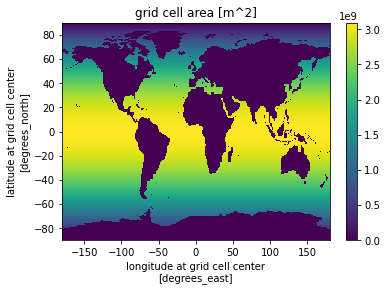

In [10]:
# mask land points
ECCO_ocean_area = ECCO_grid.area*ECCO_grid.maskC[0,:]
ECCO_ocean_area=ECCO_ocean_area.drop('Z')

ECCO_total_ocean_area = ECCO_ocean_area.sum().values

# in km^2
print(f'total ocean area: {np.round(ECCO_total_ocean_area/1e9)} km^2')
ECCO_ocean_area.plot();

plt.title('grid cell area [m^2]');

# Find the x,y points for each of the cycle days

## Load the AlongTrack x,y,t file

In [11]:
alongtrack = xr.open_dataset(str(alongtrack_file_dir) + '/AlongTrack_sample.nc', decode_times=False)
alongtrack

FileNotFoundError: [Errno 2] No such file or directory: b'/home/jovyan/GMSL/AlongTrack_sample.nc'

## Plot the cycle paths

/srv/conda/envs/notebook/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/srv/conda/envs/notebook/lib/python3.9/site-packages/cartopy/crs.py:836: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/srv/conda/envs/notebook/lib/python3.9/site-packages/cartopy/crs.py:836: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/srv/conda/envs/notebook/lib/python3.9/si

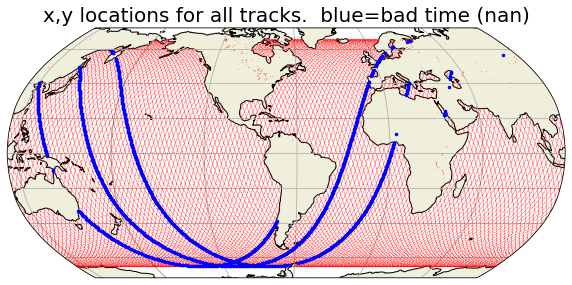

In [11]:
plt.close()
fig = plt.figure(figsize=(10,5))
ax = plt.axes(projection=ccrs.Robinson( \
              central_longitude=-67, globe=None))
ax.gridlines()
ax.add_feature(cfeature.LAND)
#ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)

kk=10
p=ax.plot(alongtrack.x[::kk],
          alongtrack.y[::kk], 'r.', markersize=0.2,\
          transform=ccrs.PlateCarree())

# plot x,y locations with nan time
ins = np.where(np.isnan(alongtrack.time.values))[0]
p=ax.plot(alongtrack.x.values[ins[::10]],
          alongtrack.y.values[ins[::10]], 'b.', markersize=5,\
          transform=ccrs.PlateCarree())

plt.title('x,y locations for all tracks.  blue=bad time (nan)', fontsize=20)
plt.show()

## Create a dictionary with x,y points for each of the 10 cycle days

In [12]:
print(alongtrack.time.min())
print(alongtrack.time.max())
print(len(alongtrack.time))

<xarray.DataArray 'time' ()>
array(0.)
<xarray.DataArray 'time' ()>
array(856657.)
604116


In [13]:
x_track_in_d = {}
y_track_in_d = {}

alongtrack_swath = {}
tc = 0
all_ins = []
for d in range(10):
    d_start = d*86400
    d_end = d_start + 86400
    ins = np.where(np.logical_and(alongtrack.time >= d_start, alongtrack.time < d_end))[0]
    
    all_ins.append(ins) 
    x_track_in_d[d],y_track_in_d[d] = utils.check_and_wrap(alongtrack.x[ins],  alongtrack.y[ins])
    
    print(f'cycle day: {d}, time_start {d_start}s, time_end {d_end}s, number of xy points {len(ins)}')
    
    tc = tc + len(ins)
    # this handy pyresample object will allow us to map from the gridded ECCO fields to the alongtrack points
    alongtrack_swath[d] =  geometry.SwathDefinition(lons=x_track_in_d[d], lats=y_track_in_d[d])
    


cycle day: 0, time_start 0s, time_end 86400s, number of xy points 59672
cycle day: 1, time_start 86400s, time_end 172800s, number of xy points 60692
cycle day: 2, time_start 172800s, time_end 259200s, number of xy points 61151
cycle day: 3, time_start 259200s, time_end 345600s, number of xy points 60718
cycle day: 4, time_start 345600s, time_end 432000s, number of xy points 61541
cycle day: 5, time_start 432000s, time_end 518400s, number of xy points 47217
cycle day: 6, time_start 518400s, time_end 604800s, number of xy points 60348
cycle day: 7, time_start 604800s, time_end 691200s, number of xy points 60832
cycle day: 8, time_start 691200s, time_end 777600s, number of xy points 61097
cycle day: 9, time_start 777600s, time_end 864000s, number of xy points 57513


In [14]:
# Note 13,335 time values are Nan!
print(f'number of nan times: {np.sum(np.isnan(alongtrack.time.values))}')

number of nan times: 13335


In [15]:
# sanity check the range of xy points 
for d in range(10):
    print(f'cycle day {d} min and max longitudes: \
        {np.nanmin(x_track_in_d[d].values), np.nanmax(x_track_in_d[d].values)}')

cycle day 0 min and max longitudes:         (-179.99866, 179.99622)
cycle day 1 min and max longitudes:         (-179.9978, 179.99731)
cycle day 2 min and max longitudes:         (-179.99811, 179.99066)
cycle day 3 min and max longitudes:         (-179.99268, 179.99951)
cycle day 4 min and max longitudes:         (-179.9971, 179.9989)
cycle day 5 min and max longitudes:         (-179.99747, 179.99402)
cycle day 6 min and max longitudes:         (-179.9989, 179.9997)
cycle day 7 min and max longitudes:         (-179.99136, 179.9993)
cycle day 8 min and max longitudes:         (-179.98523, 179.99414)
cycle day 9 min and max longitudes:         (-179.99942, 179.99695)


## Plot x,y points for each cycle day with a different color

/srv/conda/envs/notebook/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/srv/conda/envs/notebook/lib/python3.9/site-packages/cartopy/crs.py:836: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/srv/conda/envs/notebook/lib/python3.9/site-packages/cartopy/crs.py:836: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/srv/conda/envs/notebook/lib/python3.9/si

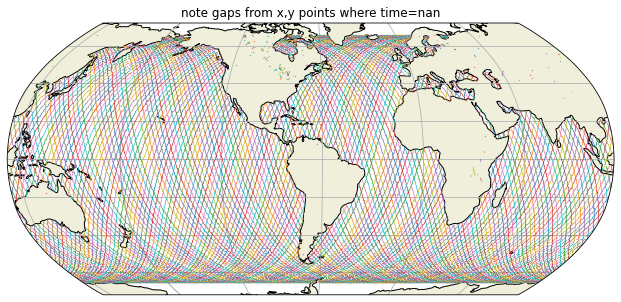

In [16]:
fig = plt.figure(figsize=(15,5))
cm = plt.get_cmap('gist_rainbow')
ax = fig.add_subplot(111)

ax = plt.axes(projection=ccrs.Robinson( \
              central_longitude=-67, globe=None))
ax.gridlines()
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)

kk=10

for d in range(10):
    p=ax.plot(x_track_in_d[d][::kk],
              y_track_in_d[d][::kk],'.', markersize=0.5,\
              transform=ccrs.PlateCarree())

plt.title('note gaps from x,y points where time=nan');

# Prepare ECCO Daily SSH dataset

In [17]:
ShortName = "ECCO_L4_SSH_05DEG_DAILY_V4R4B"

In [18]:
# Ask PODAAC for the collection id
response = requests.get(
    url='https://cmr.earthdata.nasa.gov/search/collections.umm_json', 
    params={'provider': "POCLOUD",
            'ShortName': ShortName,
            'page_size': 1}
)

ummc = response.json()['items'][0]
ccid = ummc['meta']['concept-id']
print(f'collection id: {ccid}')

collection id: C2129181904-POCLOUD


## Make a "direct connection" to the S3 file system

In [19]:
s3 = s3fs.S3FileSystem(
    key=creds['AccessKeyId'],
    secret=creds['SecretAccessKey'],
    token=creds['SessionToken'],
    client_kwargs={'region_name':'us-west-2'},
)

In [20]:
# make a S3 'filesystem' object
fs = s3fs.S3FileSystem(anon=False,
                      key=creds['AccessKeyId'],
                      secret=creds['SecretAccessKey'],
                      token=creds['SessionToken'])

## Make a list of all of the ECCO SSH dataset files for some arbitrary year

In [21]:
import time

In [1]:
year = 1992

start_time = time.time()

ECCO_SSH_files = fs.glob(join("podaac-ops-cumulus-protected/", ShortName, '*'+ str(year) + '*.nc'))
print(f'time to find urls: { time.time() - start_time} s')
print(f'time to find urls: { time.time() - start_time} s')

pprint(ECCO_SSH_files[0:5])
print('...')
pprint(ECCO_SSH_files[-5:])



NameError: name 'time' is not defined

## Load all of the files for this year from AWS S3 using 'direct connection' and combine into a single xarray DataSet object

Note: this takes a minute.

In [23]:
# from dask.distributed import Client

# client = Client("tcp://127.0.0.1:38643")
# client

In [24]:
paths=[fs.open(f) for f in ECCO_SSH_files]
print(paths[0])
print(paths[-1])

<File-like object S3FileSystem, podaac-ops-cumulus-protected/ECCO_L4_SSH_05DEG_DAILY_V4R4B/SEA_SURFACE_HEIGHT_day_mean_1992-01-01_ECCO_V4r4b_latlon_0p50deg.nc>
<File-like object S3FileSystem, podaac-ops-cumulus-protected/ECCO_L4_SSH_05DEG_DAILY_V4R4B/SEA_SURFACE_HEIGHT_day_mean_1992-12-31_ECCO_V4r4b_latlon_0p50deg.nc>


In [25]:
start_time = time.time()

ECCO_DS_daily = xr.open_mfdataset(
    paths=paths,
    combine='by_coords',
    # concat_dim='time',
    decode_cf=True,
    coords='minimal',
    chunks={'time': 1}  
)
ECCO_DS_daily.close()

print(time.time() - start_time)

52.916014194488525


## Extract the dynamic SSH field

There are three sea surface height fields in ECCO_DS, we want the dynamic SSH one.

In [26]:
ECCO_DS_daily
ECCO_SSH = ECCO_DS_daily.SSH
ECCO_SSH

<xarray.DataArray 'SSH' (time: 366, latitude: 360, longitude: 720)>
dask.array<concatenate, shape=(366, 360, 720), dtype=float32, chunksize=(1, 360, 720), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 1992-01-01T18:00:00 ... 1992-12-31T12:00:00
  * latitude   (latitude) float32 -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
  * longitude  (longitude) float32 -179.8 -179.2 -178.8 ... 178.8 179.2 179.8
Attributes:
    coverage_content_type:  modelResult
    long_name:              Dynamic sea surface height anomaly
    standard_name:          sea_surface_height_above_geoid
    units:                  m
    comment:                Dynamic sea surface height anomaly above the geoi...
    valid_min:              [-2.48615551]
    valid_max:              [2.28754616]

# Calculate the 'True' daily GMSL

In [27]:
# first call sets up the calclation in dask
# ... \sum_i [SSH_i x grid cell area_i] / total grid cell area
ECCO_global_mean_sea_level = (ECCO_SSH * ECCO_ocean_area).sum(dim=['latitude','longitude'])/ECCO_total_ocean_area

# second call actually computes it
ECCO_global_mean_sea_level = ECCO_global_mean_sea_level.compute()

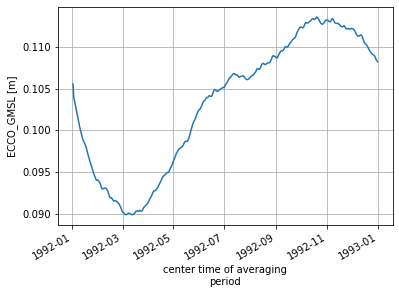

In [28]:
# Clean up the DataArray Object
ECCO_global_mean_sea_level.name = 'ECCO_GMSL'
ECCO_global_mean_sea_level.attrs['units'] = 'm'
ECCO_global_mean_sea_level.attrs['summary'] = ECCO_DS_daily.attrs['summary']
ECCO_global_mean_sea_level.plot();
plt.grid()

In [29]:
# Save to Disk
fname = output_dir / ('ECCO_V4r4_global_mean_sea_level_' + str(year) + '.nc')
ECCO_global_mean_sea_level.to_netcdf(fname)

# Extract along-track SSH from ECCO mapped SSH

## Make the GridDefinition object for the mapping procedure (use pyresample)

In [30]:
ECCO_lons, ECCO_lats = np.meshgrid(ECCO_SSH.longitude, ECCO_SSH.latitude)
ECCO_grid_def = GridDefinition(lons=ECCO_lons, lats=ECCO_lats)

In [31]:
print(ECCO_lats[0:5])
print(ECCO_lons[0:5])

[[-89.75 -89.75 -89.75 ... -89.75 -89.75 -89.75]
 [-89.25 -89.25 -89.25 ... -89.25 -89.25 -89.25]
 [-88.75 -88.75 -88.75 ... -88.75 -88.75 -88.75]
 [-88.25 -88.25 -88.25 ... -88.25 -88.25 -88.25]
 [-87.75 -87.75 -87.75 ... -87.75 -87.75 -87.75]]
[[-179.75 -179.25 -178.75 ...  178.75  179.25  179.75]
 [-179.75 -179.25 -178.75 ...  178.75  179.25  179.75]
 [-179.75 -179.25 -178.75 ...  178.75  179.25  179.75]
 [-179.75 -179.25 -178.75 ...  178.75  179.25  179.75]
 [-179.75 -179.25 -178.75 ...  178.75  179.25  179.75]]


## Loop through all days of the year, map from ECCO to the alongtrack points & Calculate 'true' global mean sea level

In [32]:
# note first dimension is time
ECCO_SSH.dims

('time', 'latitude', 'longitude')

In [44]:
# Loop through all days
for f in range(len(ECCO_SSH.time)):
# get the date/time associated with this record
    rec_time = ECCO_SSH.time[f]

    # Determine which cycle day we're in
    # ... count how many days since 1992-01-01?
    delta_days = int((rec_time.values - ECCO_start_time)/1e9/86400)

    # ... cycle day is delta_days mod 10
    cycle_day = delta_days % 10

    print(f'record day of year {str(rec_time.values)[0:10]}, cycle day {cycle_day}')

    # sample the ECCO field at the x,y locations for this cycle day 
    # search within a 200 km radius for the nearest neighbor.
    # (overkill since it's a 1 degree model but just to be safe)

    ECCO_at_xy_points =\
        kd_tree.resample_nearest(ECCO_grid_def, \
                                 ECCO_SSH[f].values, \
                                 alongtrack_swath[cycle_day],\
                                 radius_of_influence=200000)

        # make a new DataArray object
    ECCO_at_xy_points_da = xr.DataArray(ECCO_at_xy_points, dims=['i'])
    ECCO_at_xy_points_da = ECCO_at_xy_points_da.assign_coords({'time':rec_time})
    ECCO_at_xy_points_da = ECCO_at_xy_points_da.assign_coords({'cycle_day':cycle_day})
    ECCO_at_xy_points_da = ECCO_at_xy_points_da.assign_coords({'delta_days':delta_days})
    ECCO_at_xy_points_da = ECCO_at_xy_points_da.assign_coords({'lon':('i', x_track_in_d[cycle_day].values)})
    ECCO_at_xy_points_da = ECCO_at_xy_points_da.assign_coords({'lat':('i', y_track_in_d[cycle_day].values)})
    ECCO_at_xy_points_da.delta_days.attrs['comment'] = 'days since 1992-01-01'
    ECCO_at_xy_points_da.cycle_day.attrs['comment'] = 'which day in 10 day cycle'

    ECCO_at_xy_points_da.name = 'SSH_at_xy'
    ECCO_at_xy_points_da.attrs['source']='ECCO V4r4'

    # Save to Disk
    new_fname = 'ECCO_V4r4_alongtrack_SSH_' + str(rec_time.values).split('T')[0] + '.nc'
    ECCO_at_xy_points_da.to_netcdf(output_dir / new_fname)

record day of year 1992-01-01, cycle day 0
record day of year 1992-01-02, cycle day 1
record day of year 1992-01-03, cycle day 2
record day of year 1992-01-04, cycle day 3
record day of year 1992-01-05, cycle day 4
record day of year 1992-01-06, cycle day 5
record day of year 1992-01-07, cycle day 6
record day of year 1992-01-08, cycle day 7
record day of year 1992-01-09, cycle day 8
record day of year 1992-01-10, cycle day 9
record day of year 1992-01-11, cycle day 0
record day of year 1992-01-12, cycle day 1
record day of year 1992-01-13, cycle day 2
record day of year 1992-01-14, cycle day 3
record day of year 1992-01-15, cycle day 4
record day of year 1992-01-16, cycle day 5
record day of year 1992-01-17, cycle day 6
record day of year 1992-01-18, cycle day 7
record day of year 1992-01-19, cycle day 8
record day of year 1992-01-20, cycle day 9
record day of year 1992-01-21, cycle day 0
record day of year 1992-01-22, cycle day 1
record day of year 1992-01-23, cycle day 2
record day 

In [50]:
ECCO_at_xy_points_da

<xarray.DataArray 'SSH_at_xy' (i: 47217)>
array([ 0.6721609 ,  0.6721609 ,  0.6721609 , ..., -0.75799894,
       -0.75799894, -0.75799894], dtype=float32)
Coordinates:
    time        datetime64[ns] 1992-12-31T12:00:00
    cycle_day   int64 5
    delta_days  int64 365
    lon         (i) float32 91.51 91.53 91.55 91.57 ... 53.65 53.7 53.74 53.78
    lat         (i) float32 15.63 15.67 15.72 15.77 ... -46.39 -46.35 -46.31
Dimensions without coordinates: i
Attributes:
    source:   ECCO V4r4

# Plot Results for One Cycle Day

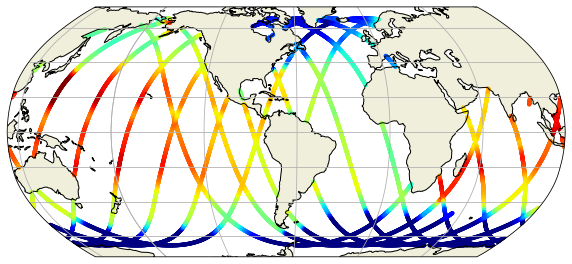

In [51]:
# This is the last processed day 

fig = plt.figure(figsize=(10,5))
cm = plt.get_cmap('gist_rainbow')
ax=fig.gca()

ax = plt.axes(projection=ccrs.Robinson( \
              central_longitude=-67, globe=None))
ax.gridlines()
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)

#plot 1 point out of 3
kk=3
p=ax.scatter(ECCO_at_xy_points_da.lon[::kk],\
             ECCO_at_xy_points_da.lat[::kk], \
             c=ECCO_at_xy_points_da[::kk], s=10,\
             transform=ccrs.PlateCarree(),vmin=-1,vmax=1, cmap='jet')


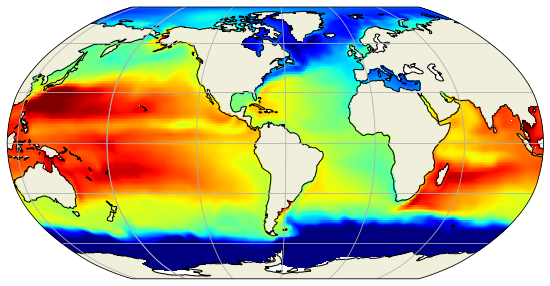

In [52]:
# and the original mapped SSH field 
fig = plt.figure(figsize=(10,5))
cm = plt.get_cmap('gist_rainbow')
ax=fig.gca()

ax = plt.axes(projection=ccrs.Robinson( \
              central_longitude=-67, globe=None))
ax.gridlines()
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)

p=ax.pcolormesh(ECCO_lons, ECCO_lats,ECCO_SSH[f],
              transform=ccrs.PlateCarree(), cmap='jet',vmin=-1,vmax=1)

# Plot 10 days of along track SSH

In [53]:
ECCO_alongtrack_files = np.sort(list(output_dir.glob('*ECCO_V4r4_alongtrack_SSH_' + str(year) + '*nc')))
ECCO_alongtrack_files

array([PosixPath('ECCO_V4r4_alongtrack_output/ECCO_V4r4_alongtrack_SSH_1992-01-01.nc'),
       PosixPath('ECCO_V4r4_alongtrack_output/ECCO_V4r4_alongtrack_SSH_1992-01-02.nc'),
       PosixPath('ECCO_V4r4_alongtrack_output/ECCO_V4r4_alongtrack_SSH_1992-01-03.nc'),
       PosixPath('ECCO_V4r4_alongtrack_output/ECCO_V4r4_alongtrack_SSH_1992-01-04.nc'),
       PosixPath('ECCO_V4r4_alongtrack_output/ECCO_V4r4_alongtrack_SSH_1992-01-05.nc'),
       PosixPath('ECCO_V4r4_alongtrack_output/ECCO_V4r4_alongtrack_SSH_1992-01-06.nc'),
       PosixPath('ECCO_V4r4_alongtrack_output/ECCO_V4r4_alongtrack_SSH_1992-01-07.nc'),
       PosixPath('ECCO_V4r4_alongtrack_output/ECCO_V4r4_alongtrack_SSH_1992-01-08.nc'),
       PosixPath('ECCO_V4r4_alongtrack_output/ECCO_V4r4_alongtrack_SSH_1992-01-09.nc'),
       PosixPath('ECCO_V4r4_alongtrack_output/ECCO_V4r4_alongtrack_SSH_1992-01-10.nc'),
       PosixPath('ECCO_V4r4_alongtrack_output/ECCO_V4r4_alongtrack_SSH_1992-01-11.nc'),
       PosixPath('ECCO_V4r4_alon

In [54]:
tmp = []
# any 10 sequential days comprises one full cycle
for d in range(10):
    tmp.append(xr.open_dataset(ECCO_alongtrack_files[d]))
    print(ECCO_alongtrack_files[d])

ECCO_V4r4_alongtrack_output/ECCO_V4r4_alongtrack_SSH_1992-01-01.nc
ECCO_V4r4_alongtrack_output/ECCO_V4r4_alongtrack_SSH_1992-01-02.nc
ECCO_V4r4_alongtrack_output/ECCO_V4r4_alongtrack_SSH_1992-01-03.nc
ECCO_V4r4_alongtrack_output/ECCO_V4r4_alongtrack_SSH_1992-01-04.nc
ECCO_V4r4_alongtrack_output/ECCO_V4r4_alongtrack_SSH_1992-01-05.nc
ECCO_V4r4_alongtrack_output/ECCO_V4r4_alongtrack_SSH_1992-01-06.nc
ECCO_V4r4_alongtrack_output/ECCO_V4r4_alongtrack_SSH_1992-01-07.nc
ECCO_V4r4_alongtrack_output/ECCO_V4r4_alongtrack_SSH_1992-01-08.nc
ECCO_V4r4_alongtrack_output/ECCO_V4r4_alongtrack_SSH_1992-01-09.nc
ECCO_V4r4_alongtrack_output/ECCO_V4r4_alongtrack_SSH_1992-01-10.nc


adding cycle day 0
adding cycle day 1
adding cycle day 2
adding cycle day 3
adding cycle day 4
adding cycle day 5
adding cycle day 6
adding cycle day 7
adding cycle day 8
adding cycle day 9


/srv/conda/envs/notebook/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/srv/conda/envs/notebook/lib/python3.9/site-packages/cartopy/crs.py:836: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/srv/conda/envs/notebook/lib/python3.9/site-packages/cartopy/crs.py:836: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/srv/conda/envs/notebook/lib/python3.9/si

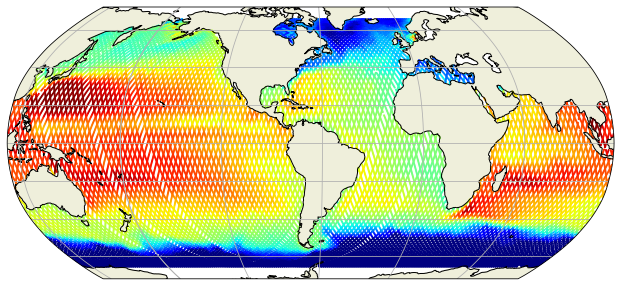

In [55]:
fig = plt.figure(figsize=(15,5))
cm = plt.get_cmap('gist_rainbow')
ax=fig.gca()

ax = plt.axes(projection=ccrs.Robinson( \
              central_longitude=-67, globe=None))
ax.gridlines()
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)

kk=12

for d in range(10):
    ECCO_at_xy = tmp[d].SSH_at_xy
    print(f'adding cycle day {ECCO_at_xy.cycle_day.values}')

    p=ax.scatter(ECCO_at_xy.lon[::kk],\
                 ECCO_at_xy.lat[::kk], \
                 c=ECCO_at_xy[::kk], s=1,\
                 transform=ccrs.PlateCarree(),
                 vmin=-1,vmax=1, cmap='jet')
